# Logistic Regression in Predicting Player Rank

Making use of the main dataset from the UCI Machine Learning Repository. We will work on a logistic regression model for the purpose of classification tasks. Afterwards, we will look into K-Means clustering to determine what number and what feature clusters best represent a player's rank.

In [4]:
"""
Import packages:
"""
import matplotlib.pyplot as plt
from sklearn import datasets, metrics, svm
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, roc_curve, auc
import numpy as np
from sklearn.preprocessing import label_binarize
import seaborn as sns
from sklearn.metrics import f1_score,precision_score,recall_score,accuracy_score
import pandas as pd

In [8]:
"""
Load in data:
"""

df = pd.read_csv('../data/starcraft.csv')

## Preprocessing Data

Simple preprocessing step to remove any NaN rows and also the `GameID` col:

In [9]:
"""
Remove GameID col because it is not important as a feature.
"""

df = df.drop('GameID', axis = 1)

In [10]:
"""
Drop any rows with NA's
"""
#dropna()
df = df.dropna()

#check the count of rows with NA's
print(df.isna().sum())

LeagueIndex           0
Age                   0
HoursPerWeek          0
TotalHours            0
APM                   0
SelectByHotkeys       0
AssignToHotkeys       0
UniqueHotkeys         0
MinimapAttacks        0
MinimapRightClicks    0
NumberOfPACs          0
GapBetweenPACs        0
ActionLatency         0
ActionsInPAC          0
TotalMapExplored      0
WorkersMade           0
UniqueUnitsMade       0
ComplexUnitsMade      0
ComplexAbilityUsed    0
MaxTimeStamp          0
dtype: int64


## EDA of Dataset:

In [29]:
"""
Check the types of each column and also summary of each column
"""
#types
print(df.dtypes)

#summary of each col
print(df.describe())

LeagueIndex             int64
Age                   float64
HoursPerWeek          float64
TotalHours            float64
APM                   float64
SelectByHotkeys       float64
AssignToHotkeys       float64
UniqueHotkeys         float64
MinimapAttacks        float64
MinimapRightClicks    float64
NumberOfPACs          float64
GapBetweenPACs        float64
ActionLatency         float64
ActionsInPAC          float64
TotalMapExplored      float64
WorkersMade           float64
UniqueUnitsMade       float64
ComplexUnitsMade      float64
ComplexAbilityUsed    float64
MaxTimeStamp            int64
dtype: object
       LeagueIndex          Age  HoursPerWeek      TotalHours          APM  \
count  3338.000000  3338.000000   3338.000000     3338.000000  3338.000000   
mean      4.120731    21.650389     15.909527      960.421809   114.575763   
std       1.448170     4.206357     11.964495    17318.133922    48.111912   
min       1.000000    16.000000      0.000000        3.000000    22.059600

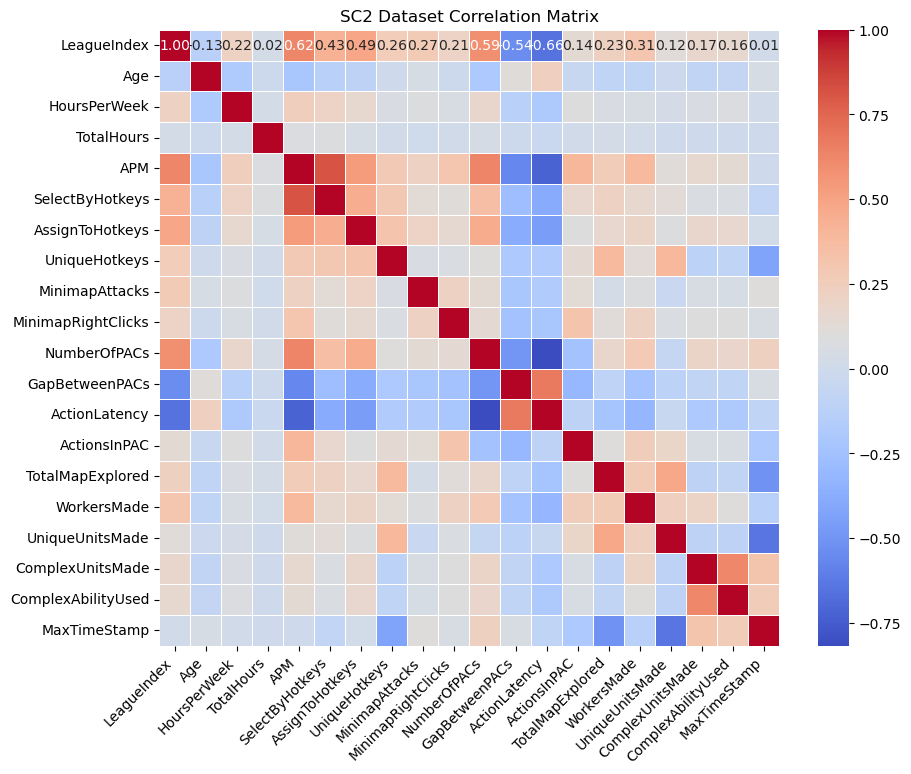

In [30]:
"""
Correlation plot of each col with each other since all columns are float or int
"""

df_corr = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(df_corr, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('SC2 Dataset Correlation Matrix')
plt.xticks(rotation=45, horizontalalignment='right')
plt.show()


Dataset Variables Descriptions:

  1. GameID: Unique ID number for each game (integer)
   2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
   3. Age: Age of each player (integer)
   4. HoursPerWeek: Reported hours spent playing per week (integer)
   5. TotalHours: Reported total hours spent playing (integer)
   6. APM: Action per minute (continuous)
   7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
   8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
   9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
  10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
  11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
  12. NumberOfPACs: Number of PACs per timestamp (continuous)
  13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
  14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
  15. ActionsInPAC: Mean number of actions within each PAC (continuous)
  16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
  17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
  18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
  19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
  20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

__Note:__

Professional leagueindex was removed because of NA's in the rows. GameID was also removed because it is uninformative for modeling later.

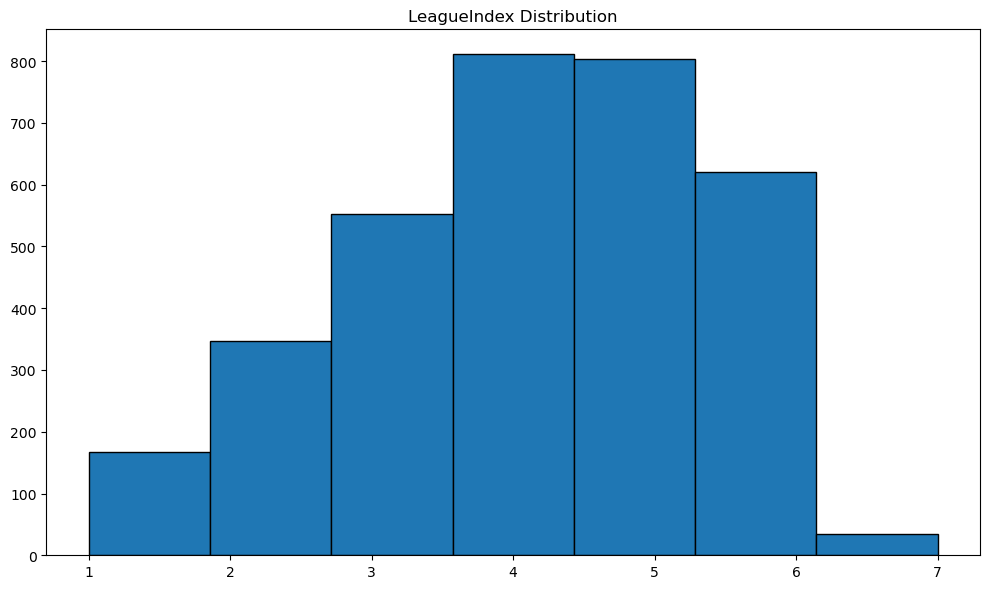

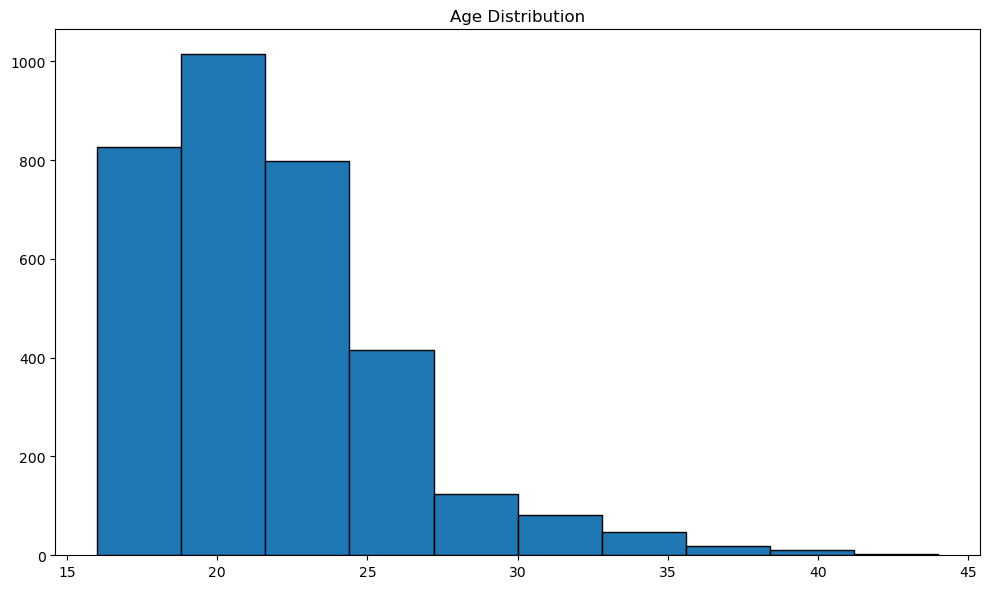

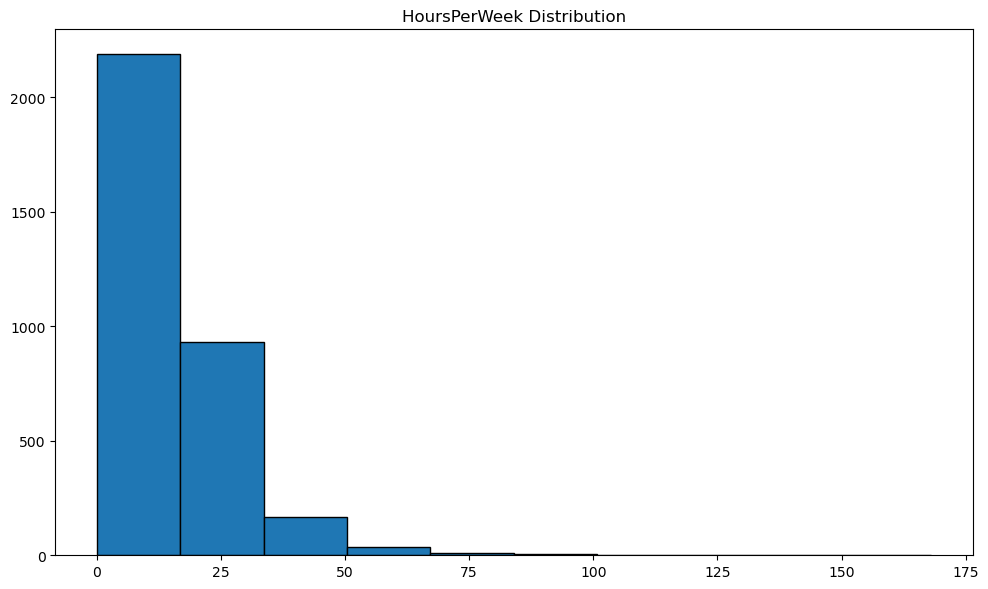

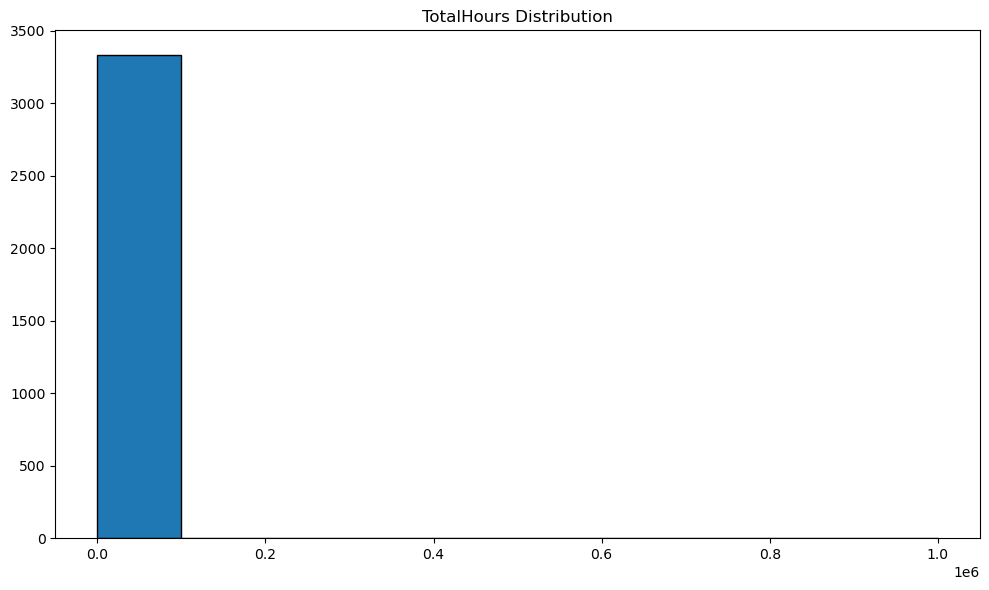

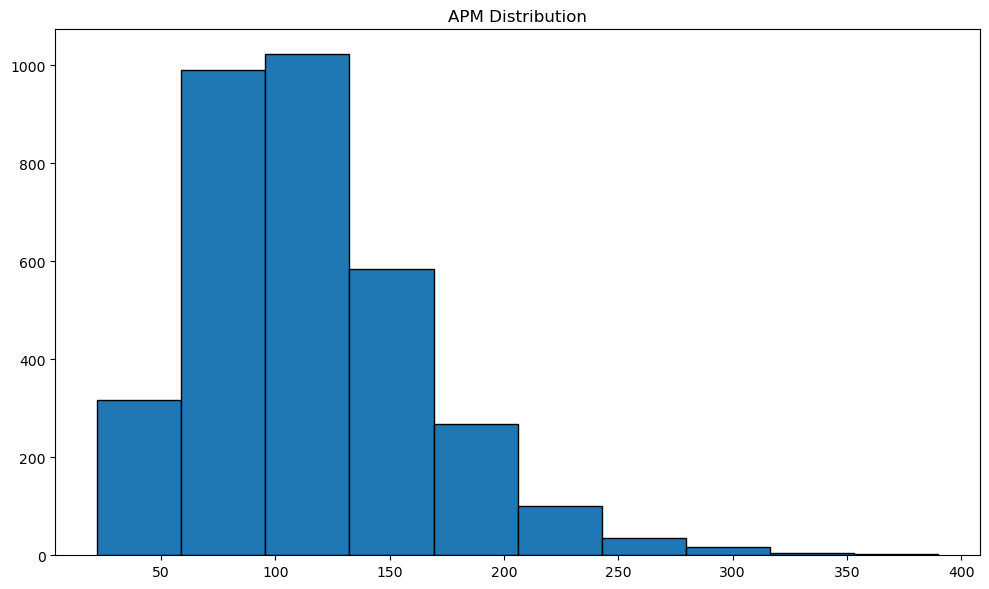

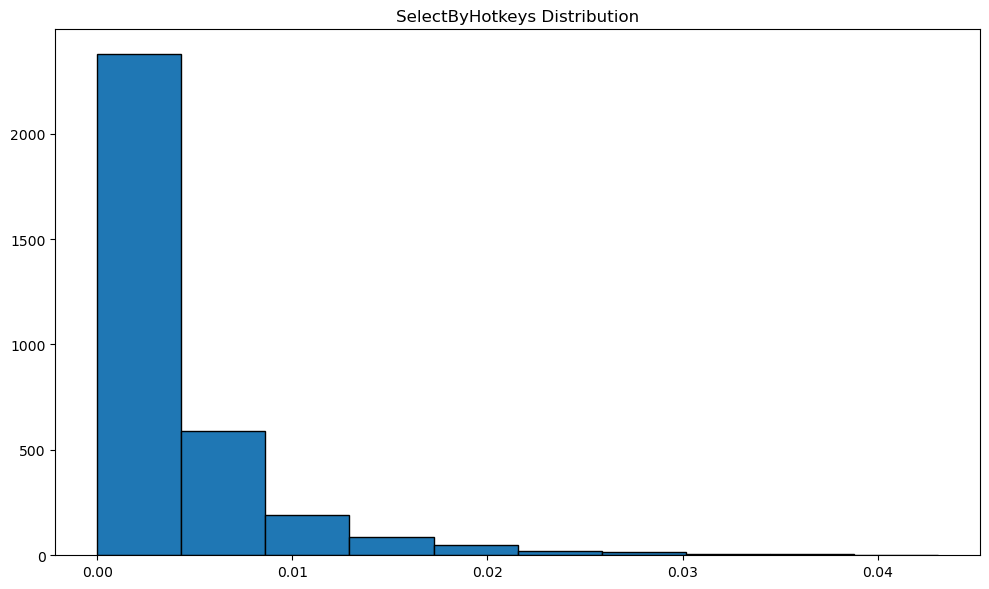

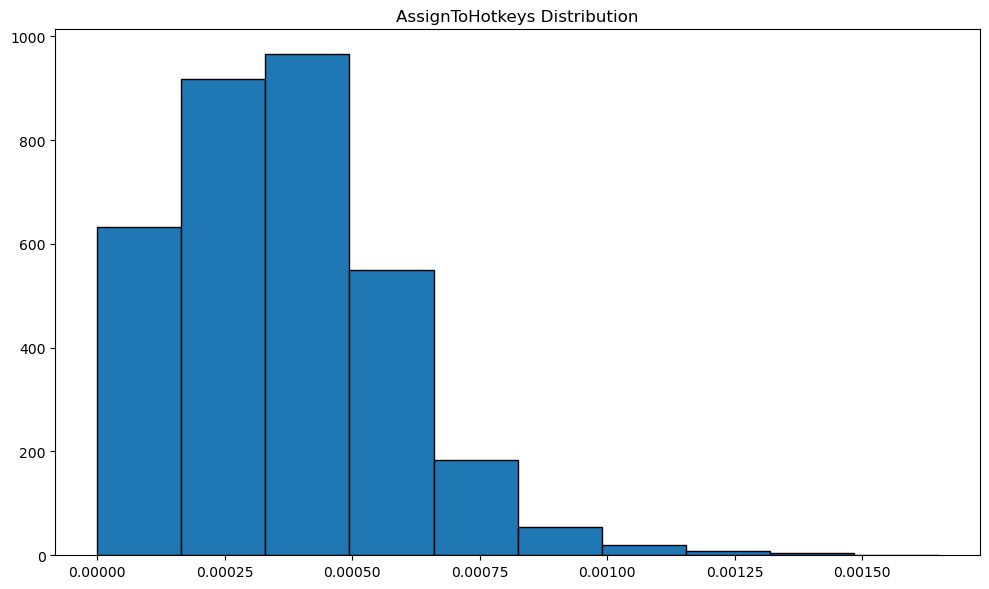

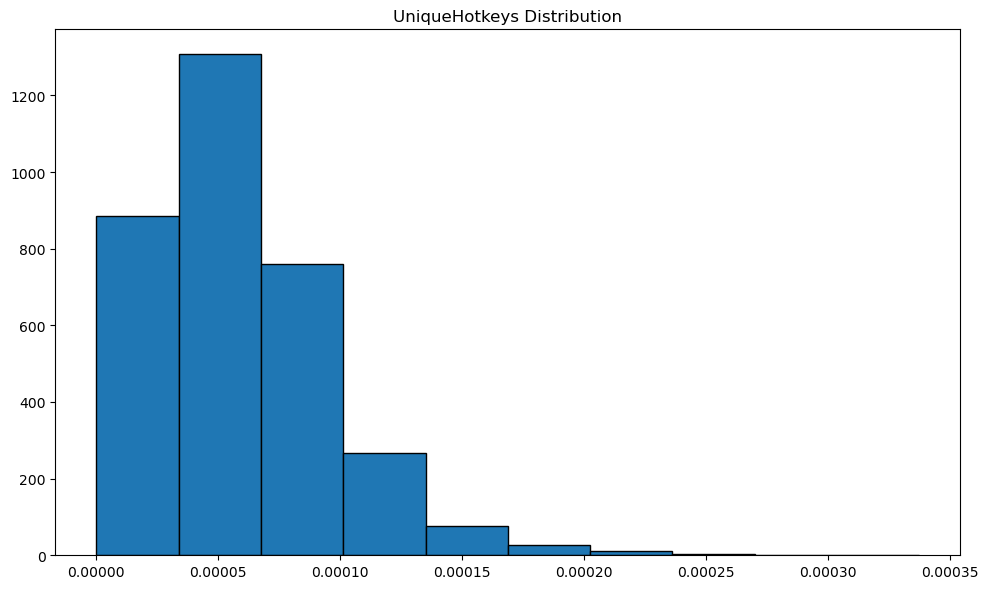

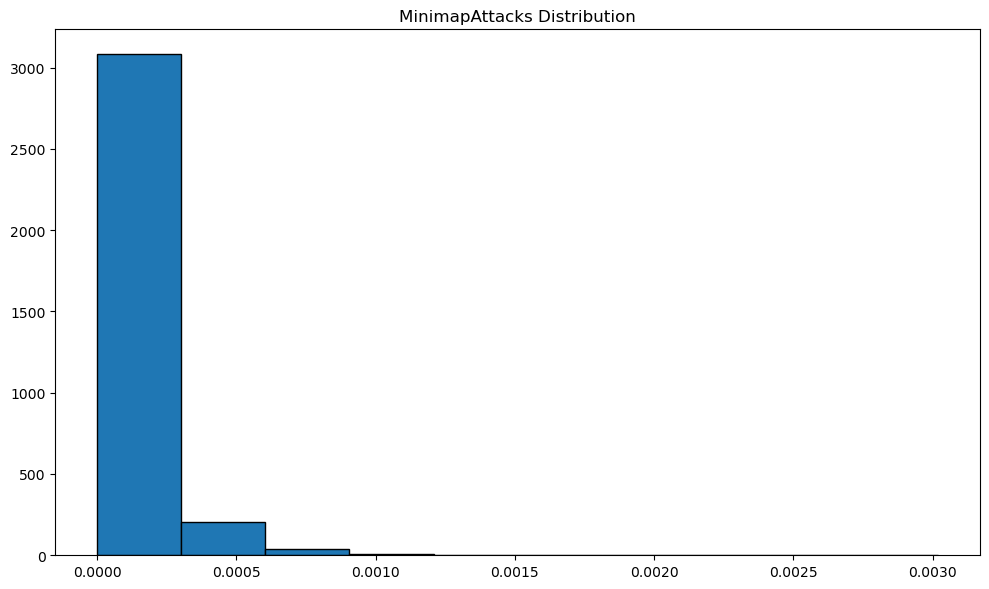

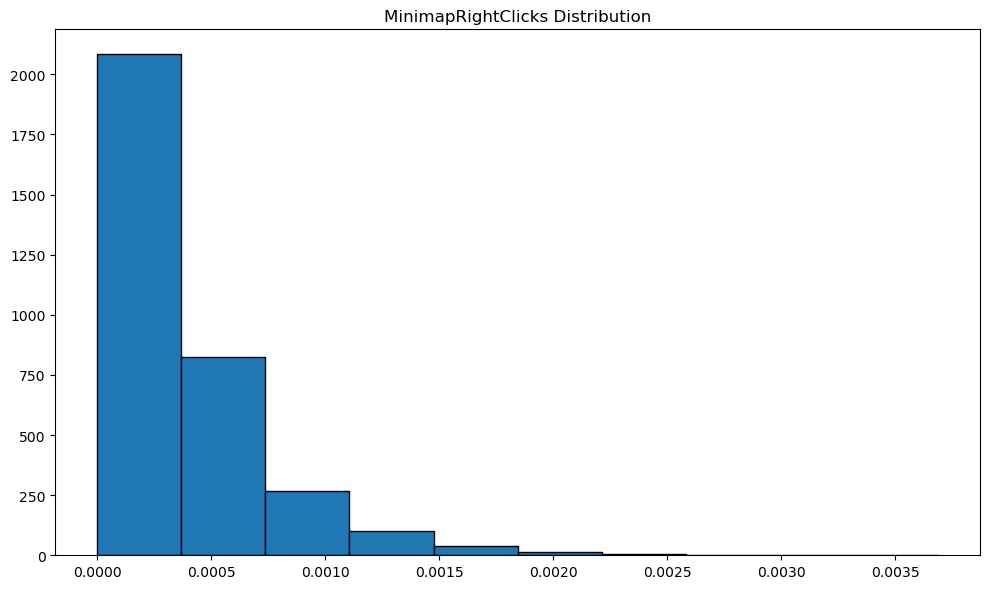

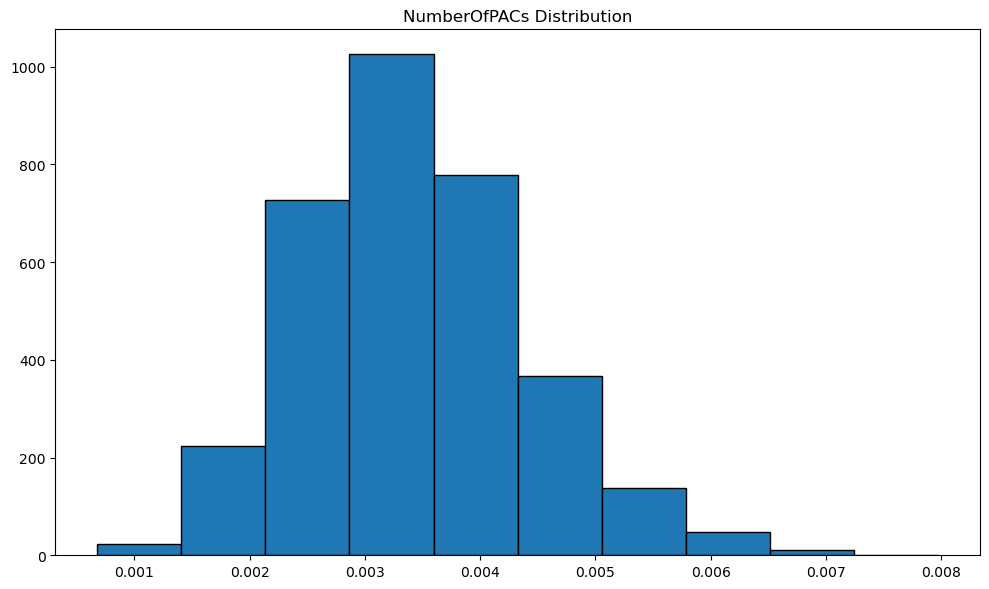

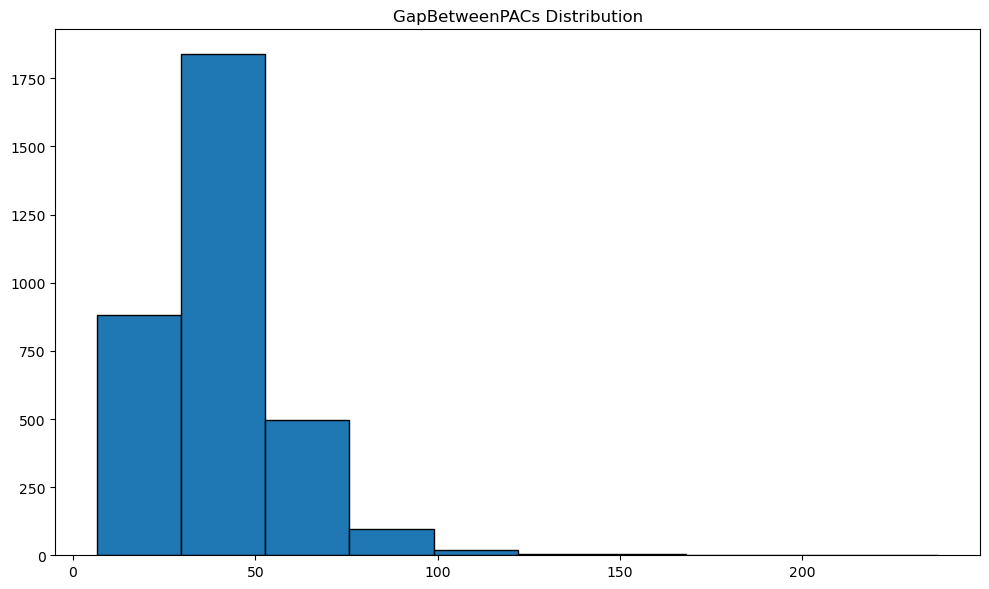

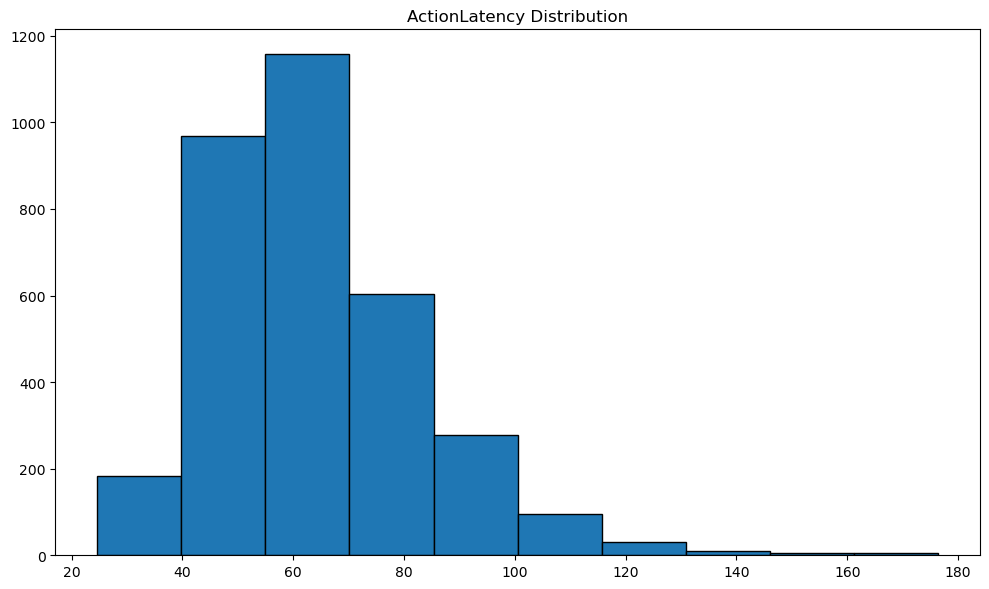

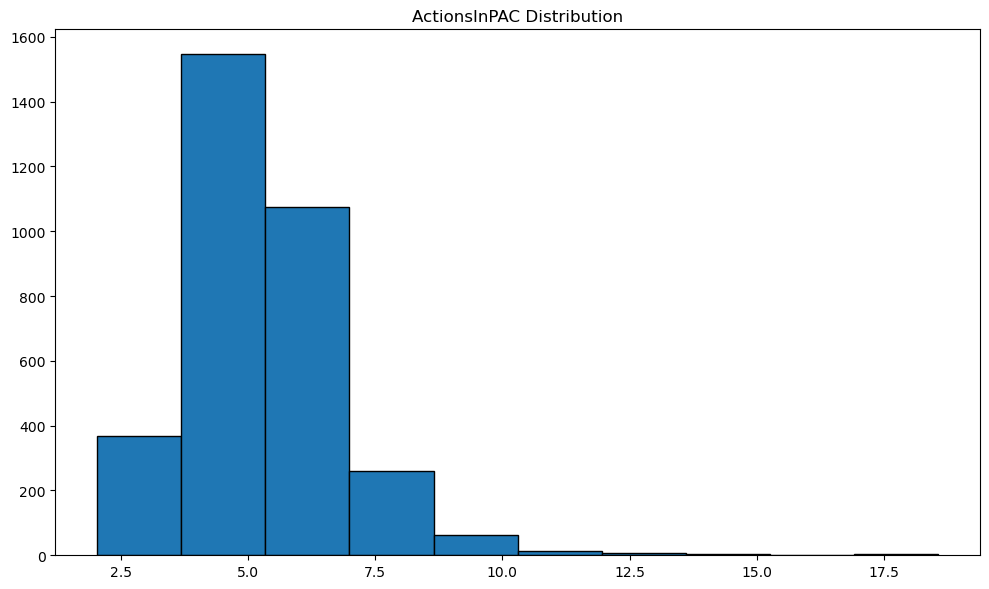

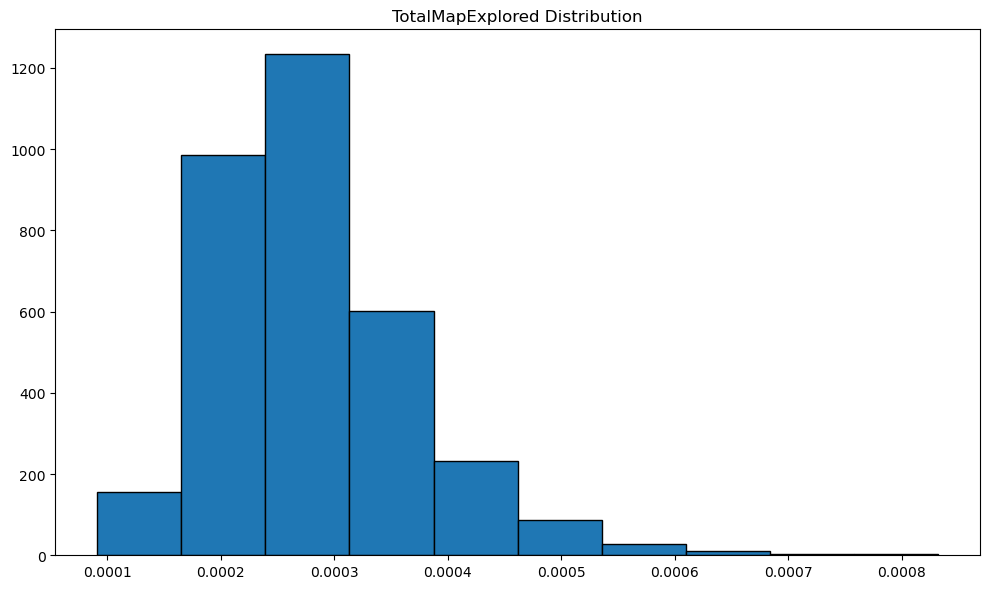

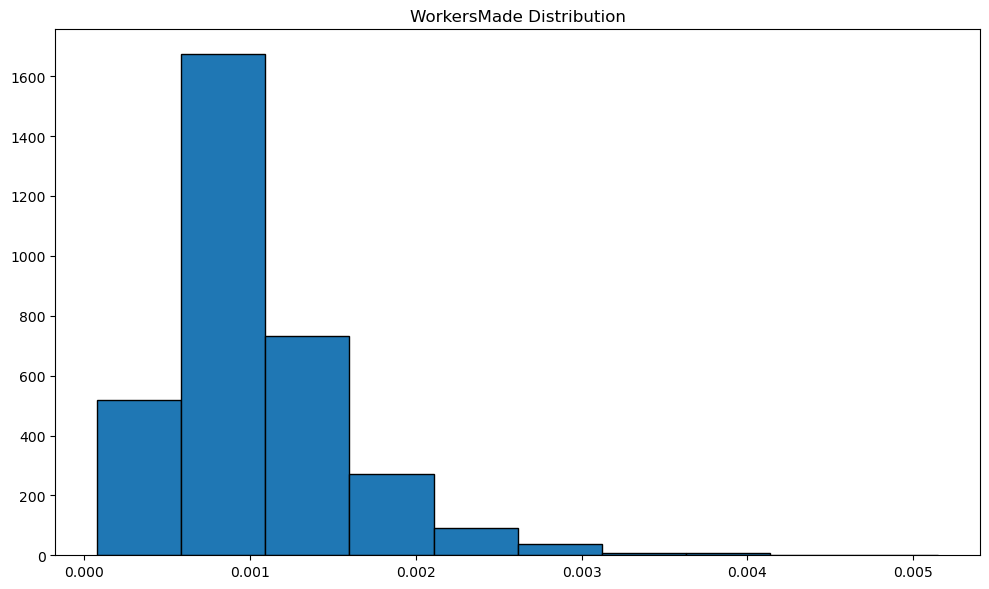

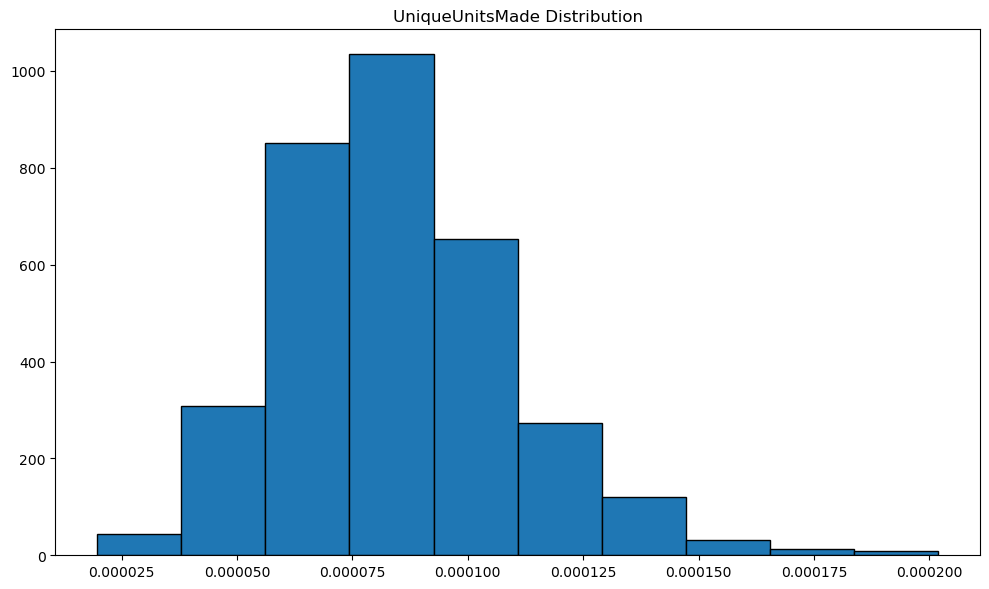

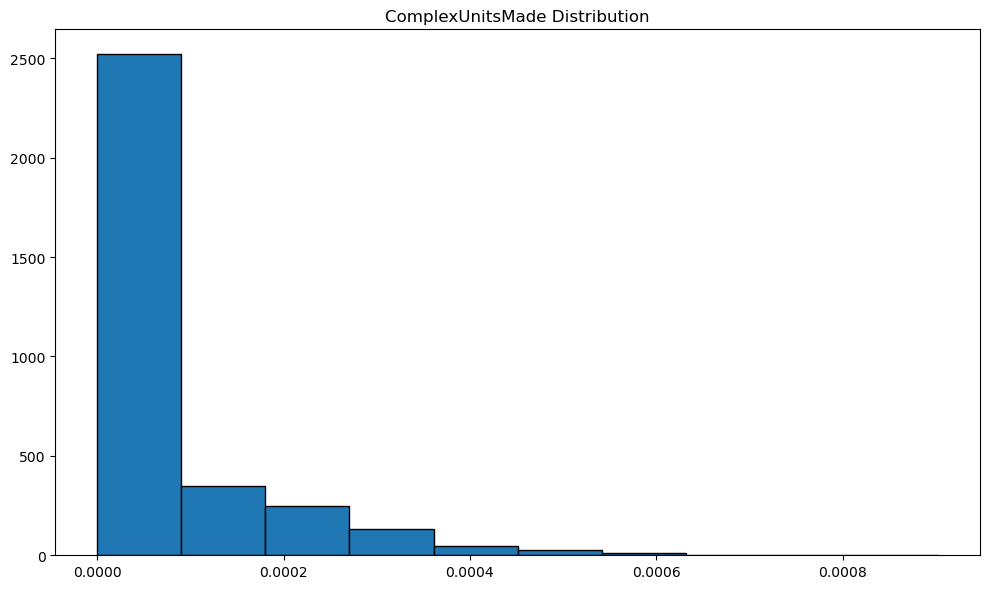

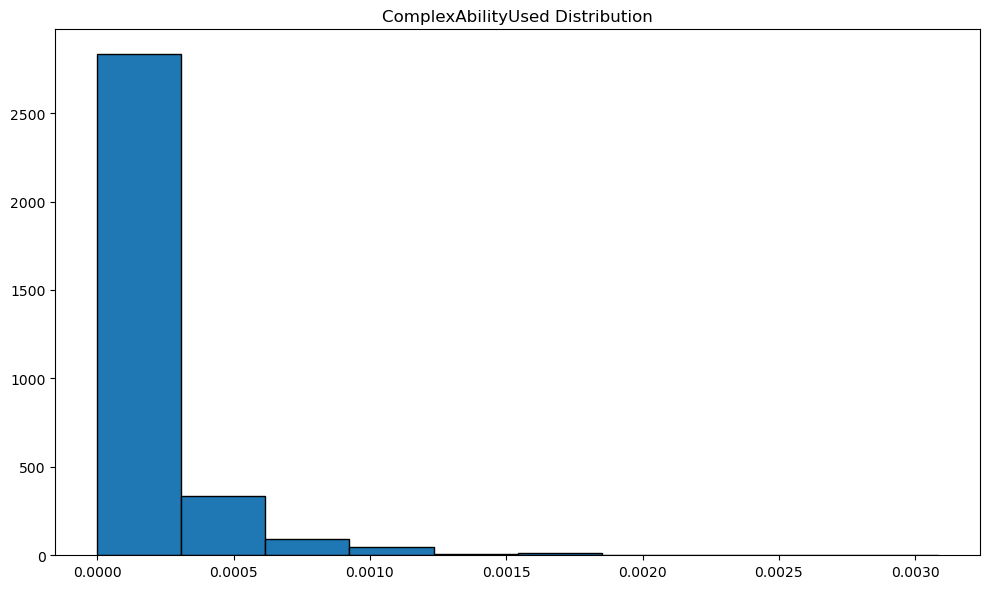

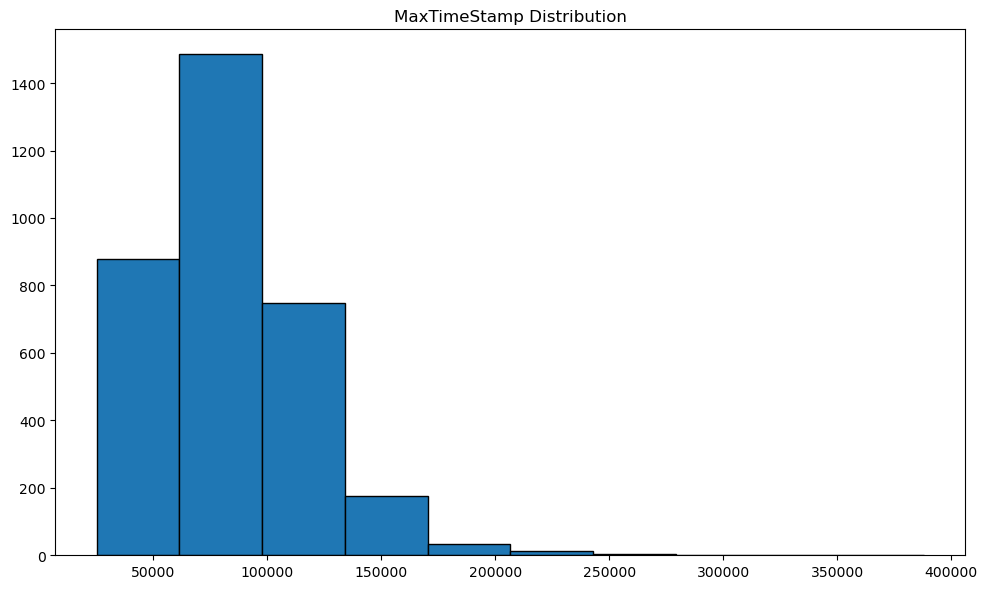

In [31]:
"""
Distribution histograms of each variable
"""

for i, col in enumerate(df.columns):
    if col == 'LeagueIndex':
        plt.figure(figsize=(10, 6))

        #get number of unique labels for leagueindex
        num_unique = df[col].nunique()
        #get bins
        num_bins = min(num_unique, 7)
        df[col].hist(bins = num_bins, edgecolor = 'black', grid = False)
        plt.title(f'{col} Distribution')
        plt.tight_layout()
        plt.show()

    else:
        plt.figure(figsize=(10, 6))
        df[col].hist(edgecolor = 'black', grid = False)

        plt.title(f'{col} Distribution')
        plt.tight_layout()
        plt.show()

- All distributions are either skewed right (everything huddles around earlier x-values) or normally distributed.
- Rank or `LeagueIndex` is the most important target for our project:
  - Most players are in `platinum` or `diamond` it seems.

## Logistic Regression Modeling

In [16]:
"""
First split dataset into 70-15-15 for training, testing, and validation.
"""
#split it into x and y first
#y = leagueindex
#x = the rest of the features
y = df['LeagueIndex']
x = df.drop('LeagueIndex', axis = 1)

#train_test_split() the x and y: 70%/15%/15%
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.3)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5)

#print shapes of x and y for train, val, and test
print('-----------------------')
print('Training:')
print(x_train.shape)
print(y_train.shape)
print('-----------------------')
print('Validation:')
print(x_val.shape)
print(y_val.shape)
print('-----------------------')
print('Testing:')
print(x_test.shape)
print(y_test.shape)

-----------------------
Training:
(2336, 19)
(2336,)
-----------------------
Validation:
(501, 19)
(501,)
-----------------------
Testing:
(501, 19)
(501,)


In [17]:
"""
Make logistic regression classifier and fit
"""

#create log reg model with init hyperparams
model = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver = 'saga', max_iter = 10000, random_state = 113)
#fit with training
model.fit(x_train, y_train)


LogisticRegression(l1_ratio=0, max_iter=10000, penalty='elasticnet',
                   random_state=113, solver='saga')

In [18]:
"""
Parameter tune with different hyperparams using GridSearchCV from sklearn
"""

#define param_grid for hypertuning
param_grid = {
    'l1_ratio' : np.linspace(0,1,5),
    'C' : [0.01, 0.1, 1, 10]
    
}


#grid search it to fine optimal params
grid_search = GridSearchCV(model, param_grid, cv=10, return_train_score=True,scoring='accuracy')

#fit with val dataset
grid_search.fit(x_val, y_val)

#optimal params
best_params = grid_search.best_params_

c:\Users\xusha\anaconda3\envs\dsan6600\Lib\site-packages\sklearn\model_selection\_split.py:725: UserWarning: The least populated class in y has only 6 members, which is less than n_splits=10.
  warnings.warn(


In [19]:
#print the best parameters for future use:
print(best_params)

#OUTPUT:
#{'C': 0.01, 'l1_ratio': 0.0}

{'C': 0.01, 'l1_ratio': 0.0}


In [20]:
"""
Make model again with best parameters with initial parameters and fit again with training.
"""
#make best model and fit with training again
best_model = LogisticRegression(penalty='elasticnet', l1_ratio = 0, solver = 'saga', max_iter = 10000, 
                   C = 0.01, random_state = 113).fit(x_train, y_train)


In [23]:
"""
Predict with test dataset and get metrics. Also calculate ROC for each class.
"""
#get predictions for test dataset
test_preds = best_model.predict(x_test)
#make confusion matrix
conf = confusion_matrix(y_test, test_preds)
#get accuracy, recall, prec, and f1
acc = accuracy_score(y_test, test_preds)
prec = precision_score(y_test, test_preds, average = 'micro')
recall = recall_score(y_test, test_preds, average = 'micro')
f1 = f1_score(y_test, test_preds, average = 'micro')



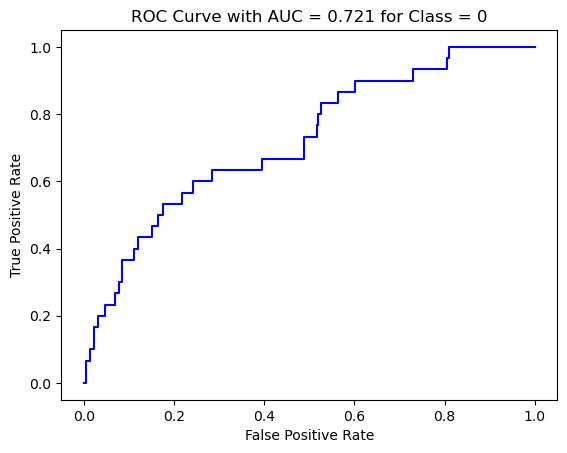

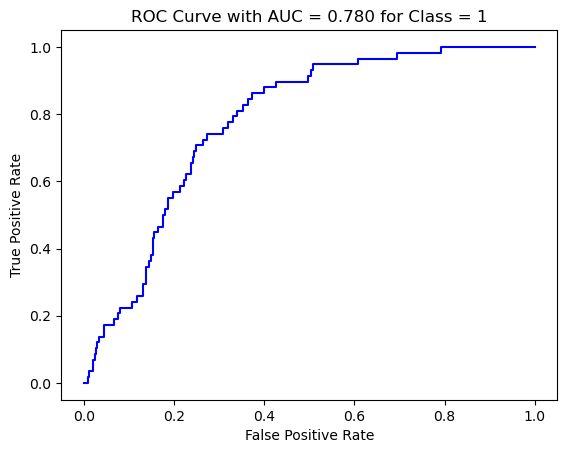

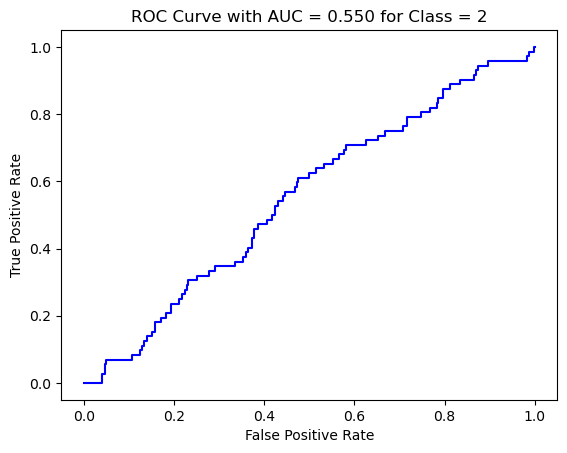

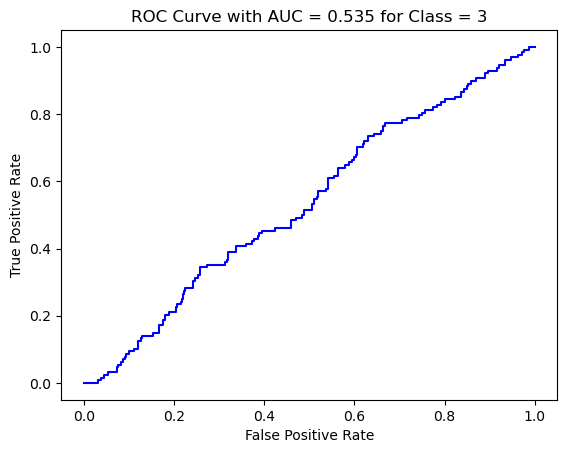

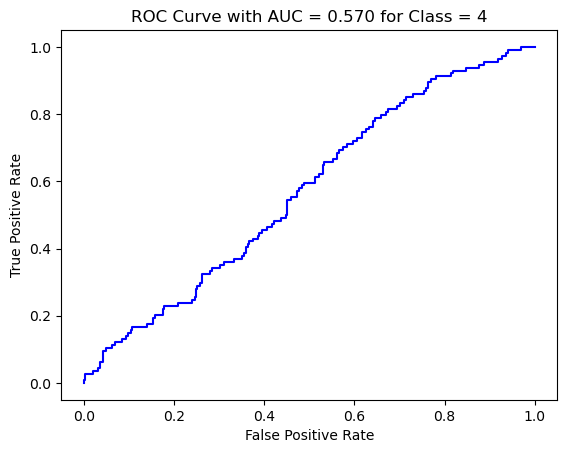

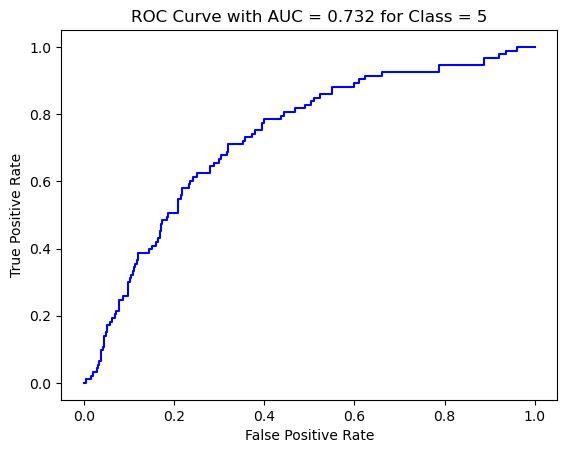

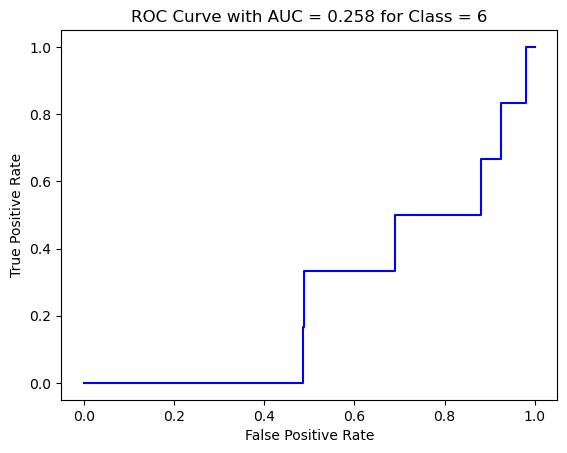

-----------------------------------------------
Classification Report of Latest Fit's Metrics on Test Data:
Test Accuracy Score: 0.2694610778443114
Test Precision Score: 0.2694610778443114
Test Recall Score: 0.2694610778443114
Test F1 Score: 0.2694610778443114


In [28]:
"""
report metrics and also ROC plot
"""
#get scores for each class in x_test
y_scores = model.predict_proba(x_test)

#binarize y_test
bin_y_test = label_binarize(y_test, classes=np.unique(y_test))
fpr = {}
tpr = {}
auc_plot = {}
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(bin_y_test[:,i], y_scores[:,i])
    auc_plot[i] = auc(fpr[i], tpr[i])
#plot ROC for each class
for i in range(len(np.unique(y_test))):
    plt.figure()
    plt.plot(fpr[i], tpr[i], 'b')
    plt.title('ROC Curve with AUC = %0.3f for Class = %d' % (auc_plot[i], i))
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

print('-----------------------------------------------')
print("Classification Report of Latest Fit's Metrics on Test Data:")
print('Test Accuracy Score:', acc)
print('Test Precision Score:', prec)
print('Test Recall Score:', recall)
print('Test F1 Score:', f1)


## Model Conclusions

Logistic Regression seems to not work too well with the non-linearity of the data and its multi-class labels. 

Next, we will do some clustering to examine feature clusters through K-means clustering. This will help us know which clusters best represent players' ranks.

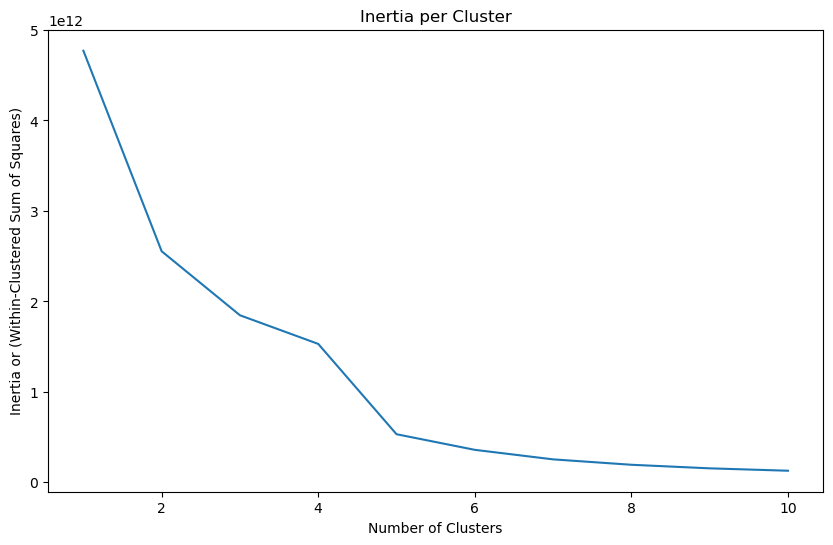

In [32]:
"""
Perform k-means clustering
"""
from sklearn.cluster import KMeans

#init inertia list and max number of clusters
inertia = []

#perform kmeans with different number of clusters
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init ='random', n_init=10, max_iter=500)
    kmeans.fit(x)
    inertia.append(kmeans.inertia_)

#plot to see inertia per cluster number
plt.figure(figsize=(10,6))
plt.plot(range(1, 10 + 1), inertia)
plt.title('Inertia per Cluster')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia or (Within-Clustered Sum of Squares)')
plt.show()


__Observations:__

It seems the most optimal number of clusters for K-means clustering is around 5-7 clusters. Therefore, we will perform K-means again using 6 clusters.

In [37]:
"""
Clustering with K-means again with 6 number of clusters. Using silhouette scoring, we can see which 
top 3 features are most relevant in clustering the features.
"""
from sklearn.metrics import silhouette_score

sil_scores = {}

#for each feature, determine avg silhouette scores after fitting and predicting then store
for feature in x.columns:
    curr_kmeans = KMeans(n_clusters=6, init ='random', n_init=10, max_iter=500, random_state=5555)
    curr_clus_labels = curr_kmeans.fit_predict(x[[feature]])
    sil_avg = silhouette_score(x[[feature]], curr_clus_labels)
    sil_scores[feature] = sil_avg


#sort the avg silhouette scores for each feature
sorted_sil = sorted(sil_scores.items(), key = lambda x: x[1], reverse = True)

#report the top 3 features for clustering
for  i, (feature,score) in enumerate(sorted_sil[:3]):
    print(f'Top Feature {i+1} - {feature}: Silhouette score = {score}')

Top Feature 1 - ComplexUnitsMade: Silhouette score = 0.8352553692797913
Top Feature 2 - ComplexAbilityUsed: Silhouette score = 0.7300666059102613
Top Feature 3 - MinimapAttacks: Silhouette score = 0.6449434173839843


__Observations:__

Surprisingly, `APM` was not the best feature to create clusters. `APM` was 13th place in terms of silhouette score actually (for random_state = 5555). `ComplexUnitsMade`, `ComplexAbilityUsed`, and `MinimapAttacks` were the best features for clustering according to silhouette scores.

In [39]:
sorted_sil

[('ComplexUnitsMade', 0.8352553692797913),
 ('ComplexAbilityUsed', 0.7300666059102613),
 ('MinimapAttacks', 0.6449434173839843),
 ('HoursPerWeek', 0.6107493473011815),
 ('Age', 0.5996385199825349),
 ('SelectByHotkeys', 0.5564748356022245),
 ('MinimapRightClicks', 0.5510457964078767),
 ('TotalHours', 0.5453902255181826),
 ('MaxTimeStamp', 0.5366273455410393),
 ('AssignToHotkeys', 0.5346841896462874),
 ('GapBetweenPACs', 0.5332126471692127),
 ('UniqueHotkeys', 0.5328877630280293),
 ('APM', 0.532489292736675),
 ('WorkersMade', 0.5286754595233646),
 ('ActionLatency', 0.5267067263066015),
 ('NumberOfPACs', 0.5252805148565762),
 ('ActionsInPAC', 0.5233139748758064),
 ('TotalMapExplored', 0.5224860937114976),
 ('UniqueUnitsMade', 0.5184675462232793)]

# ADD TOP 2 FEATURE CLUSTERS PLOTTING